## Estimation of count models- seriousInjuryCounts using NegativeBinomial Regression

#### libraries and data loading

In [1]:
#!pip install fast_ml
# !pip install mlxtend
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrices

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import PoissonRegressor,LogisticRegression
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns",None)
sns.set_theme()

In [2]:
df = pd.read_csv('CASpreprocessed.csv')              
df.drop('Unnamed: 0',axis =1, inplace=True)
target = 'seriousInjuryCount'

In [3]:
df.head()

,X,Y,bicycle,bridge,bus,carStationWagon,cliffBank,crashDirectionDescription,crashFinancialYear,crashLocation1,crashLocation2,crashSeverity,crashSHDescription,crashYear,debris,directionRoleDescription,ditch,fatalCount,fence,flatHill,guardRail,houseOrBuilding,kerb,light,minorInjuryCount,moped,motorcycle,NumberOfLanes,objectThrownOrDropped,otherObject,otherVehicleType,overBank,parkedVehicle,phoneBoxEtc,postOrPole,region,roadCharacter,roadLane,roadSurface,roadworks,schoolBus,seriousInjuryCount,slipOrFlood,speedLimit,strayAnimal,streetLight,suv,taxi,tlaName,trafficControl,trafficIsland,trafficSign,train,tree,truck,unknownVehicleType,urban,vanOrUtility,vehicle,waterRiver,weatherA
0,1772561.0,5896382.0,0.0,0.0,0.0,1.0,0.0,NaN,2007/2008,EAST ST,ELLIOT ST,Non-Injury Crash,No,2007,0.0,North,0.0,0.0,0.0,Flat,0.0,0.0,0.0,Dark,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Auckland Region,Nil,2-way,Sealed,0.0,0.0,0.0,0.0,50.0,0.0,On,1.0,0.0,Auckland,Traffic Signals,0.0,0.0,0.0,0.0,0.0,0.0,Urban,0.0,0.0,0.0,Fine
1,1836757.0,5859311.0,0.0,0.0,0.0,2.0,0.0,NaN,2002/2003,SH 2,SH 26,Non-Injury Crash,Yes,2003,0.0,North,0.0,0.0,0.0,Flat,0.0,0.0,0.0,Dark,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Waikato Region,Nil,2-way,Sealed,0.0,0.0,0.0,0.0,50.0,0.0,On,0.0,0.0,Hauraki District,Give way,0.0,0.0,0.0,0.0,0.0,0.0,Urban,0.0,0.0,0.0,Fine
2,1762088.0,5912507.0,0.0,0.0,0.0,1.0,0.0,West,2009/2010,CHURCH ST,HUGO JOHNSTON DRIVE,Non-Injury Crash,No,2010,0.0,East,0.0,0.0,0.0,Flat,0.0,0.0,0.0,Bright sun,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Auckland Region,Nil,2-way,Sealed,0.0,0.0,0.0,0.0,50.0,0.0,Off,0.0,0.0,Auckland,Traffic Signals,0.0,0.0,0.0,0.0,0.0,0.0,Urban,1.0,0.0,0.0,Fine
3,1753522.0,5911939.0,0.0,0.0,0.0,2.0,0.0,NaN,2017/2018,THE AVENUE,ACCESSWAY,Minor Crash,No,2017,0.0,North,0.0,0.0,0.0,Hill Road,0.0,0.0,0.0,Overcast,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Auckland Region,Nil,2-way,Sealed,0.0,0.0,0.0,0.0,50.0,0.0,NaN,0.0,0.0,Auckland,Nil,0.0,0.0,0.0,0.0,0.0,0.0,Urban,0.0,0.0,0.0,Light rain
4,1761364.0,5914259.0,0.0,0.0,0.0,2.0,0.0,NaN,2017/2018,PENROSE INT,GT SOUTH LINK,Non-Injury Crash,No,2018,0.0,North,0.0,0.0,0.0,Flat,0.0,0.0,0.0,Overcast,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Auckland Region,Motorway ramp,1-way,Sealed,0.0,0.0,0.0,0.0,50.0,0.0,NaN,0.0,0.0,Auckland,Give way,0.0,0.0,0.0,0.0,0.0,0.0,Urban,0.0,0.0,0.0,Fine


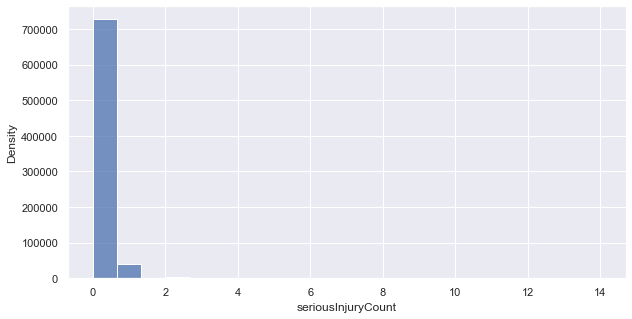

In [4]:
plt.figure(figsize=(10,5))
plt.xlabel('seriousInjuryCount')
plt.ylabel('Density')
sns.histplot(df['seriousInjuryCount'])
plt.show()

In [5]:
df['sc'] = df.apply(
    lambda row: 5 if row['seriousInjuryCount'] >=5 else row['seriousInjuryCount'] ,
    axis=1
)

In [6]:
df.sc.value_counts()

0.0    727346
1.0     40180
2.0      4334
3.0       863
4.0       258
5.0       126
Name: sc, dtype: int64

In [7]:
df.shape

(773107, 62)

In [8]:
null_columns = df.columns[df.isnull().any()]
(df[null_columns].isnull().sum()/len(df))*100

crashDirectionDescription    37.636964
crashLocation2                0.115379
directionRoleDescription      0.403566
flatHill                      0.733275
roadLane                      0.064027
roadSurface                   0.118224
streetLight                  38.163411
weatherA                      1.710242
dtype: float64

#### functions

In [9]:
def multicollinearity_assumption(model, features, label, feature_names=None):        
    plt.figure(figsize = (10,8))
    sns.heatmap(pd.DataFrame(features, columns=feature_names).corr(), annot=True)
    plt.title('Correlation of Variables')
    plt.show()
        
    print('Variance Inflation Factors (VIF)')
    print('> 10: An indication that multicollinearity may be present')
    print('> 100: Certain multicollinearity among the variables')
    print('-------------------------------------')
       
    VIF = [variance_inflation_factor(features, i) for i in range(features.shape[1])]
    for idx, vif in enumerate(VIF):
        print('{0}: {1}'.format(feature_names[idx], vif))
        
    possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
    definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
    print()
    print('{0} cases of possible multicollinearity'.format(possible_multicollinearity))
    print('{0} cases of definite multicollinearity'.format(definite_multicollinearity))
    print()

    if definite_multicollinearity == 0:
        if possible_multicollinearity == 0:
            print('Assumption satisfied')
        else:
            print('Assumption possibly satisfied')

    else:
        print('Assumption not satisfied')
        print()
        print('Coefficient interpretability will be problematic')
        print('Consider removing variables with a high Variance Inflation Factor (VIF)')

In [10]:
def calculate_residuals(model, features, label):
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label.squeeze(1), 'Predicted': predictions})
    df_results['PredictedT'] = np.round(df_results['Predicted'])
    df_results['Residuals'] = (df_results['Actual'] - df_results['Predicted'])
        
    return df_results

In [11]:
def homoscedasticity_assumption(model, features, label):     
    df_results = calculate_residuals(model, features, label)

    plt.subplots(figsize=(12, 6))
    ax = plt.subplot(111)
    plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
    plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    plt.title('Residuals')
    plt.show()  

In [12]:
def normal_errors_assumption(model, features, label):
    df_results = calculate_residuals(model, features, label) 
    plt.subplots(figsize=(12, 6))
    plt.title('Distribution of Residuals')
    sns.distplot(df_results['Residuals'])
    plt.show()

In [13]:
def Feature_imp(Model,n,X,y):
    model = Model
    # create the RFE model and select attributes
    rfe = RFE(model,n_features_to_select= n)              # Recursive feature elimination.
    rfe = rfe.fit(X, y)
    # summarize the selection of the attributes
    return pd.DataFrame({'Decision':rfe.support_,'Ranking':rfe.ranking_,'Feature':X.columns})  

#### modelling

In [14]:
df[target].var()-df[target].mean()

0.02193029519586978

In [15]:
df['tree'].value_counts()

0.0    742171
1.0     30685
2.0       247
3.0         4
Name: tree, dtype: int64

In [16]:
# drop columns which depends on serious injury count or any injury count.

formula = "sc ~ roadCharacter+roadSurface+trafficSign+carStationWagon+cliffBank+debris+ditch+fence+guardRail+houseOrBuilding+motorcycle+NumberOfLanes+overBank+parkedVehicle+postOrPole+schoolBus+slipOrFlood+speedLimit+tree+urban+vanOrUtility+vehicle"

y, X = dmatrices(formula, df, return_type='dataframe')
X.drop("Intercept",axis=1,inplace=True)

In [17]:
X.columns

Index(['roadCharacter[T.Motorway ramp]', 'roadCharacter[T.Nil]',
       'roadCharacter[T.Overpass]', 'roadCharacter[T.Rail xing]',
       'roadCharacter[T.Speed hump]', 'roadCharacter[T.Tram lines]',
       'roadCharacter[T.Tunnel]', 'roadCharacter[T.Underpass]',
       'roadSurface[T.Sealed]', 'roadSurface[T.Unsealed]', 'urban[T.Urban]',
       'trafficSign', 'carStationWagon', 'cliffBank', 'debris', 'ditch',
       'fence', 'guardRail', 'houseOrBuilding', 'motorcycle', 'NumberOfLanes',
       'overBank', 'parkedVehicle', 'postOrPole', 'schoolBus', 'slipOrFlood',
       'speedLimit', 'tree', 'vanOrUtility', 'vehicle'],
      dtype='object')

In [18]:
X.count(), len(X.columns)

(roadCharacter[T.Motorway ramp]    772193
 roadCharacter[T.Nil]              772193
 roadCharacter[T.Overpass]         772193
 roadCharacter[T.Rail xing]        772193
 roadCharacter[T.Speed hump]       772193
 roadCharacter[T.Tram lines]       772193
 roadCharacter[T.Tunnel]           772193
 roadCharacter[T.Underpass]        772193
 roadSurface[T.Sealed]             772193
 roadSurface[T.Unsealed]           772193
 urban[T.Urban]                    772193
 trafficSign                       772193
 carStationWagon                   772193
 cliffBank                         772193
 debris                            772193
 ditch                             772193
 fence                             772193
 guardRail                         772193
 houseOrBuilding                   772193
 motorcycle                        772193
 NumberOfLanes                     772193
 overBank                          772193
 parkedVehicle                     772193
 postOrPole                       

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [20]:
X_train.shape , X_test.shape , y_train.shape , y_test.shape

((617754, 30), (154439, 30), (617754, 1), (154439, 1))

In [21]:
Feature = Feature_imp(PoissonRegressor(),10,X_train,y_train)              # PoissonRegressor,  # DecisionTreeClassifier(), LogisticRegression()

In [22]:
lis = Feature[Feature.Decision==True]

In [23]:
lis['Feature'].unique()

array(['roadCharacter[T.Motorway ramp]', 'carStationWagon', 'fence',
       'guardRail', 'motorcycle', 'NumberOfLanes', 'parkedVehicle',
       'postOrPole', 'speedLimit', 'tree'], dtype=object)

In [24]:
X_train_poi = X[lis['Feature'].unique()]
y_train_poi = y

In [25]:
type(X_train_poi),type(y_train_poi)

(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame)

In [26]:
X_train_poi.shape

(772193, 10)

### Poisson fit for the selected columns

In [27]:
model_poi = sm.GLM(y_train_poi, X_train_poi,family=sm.families.Poisson()).fit()
print(model_poi.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     sc   No. Observations:               772193
Model:                            GLM   Df Residuals:                   772183
Model Family:                 Poisson   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.9818e+05
Date:                Sat, 23 Apr 2022   Deviance:                   3.0081e+05
Time:                        20:13:57   Pearson chi2:                 1.92e+06
No. Iterations:                     7   Pseudo R-squ. (CS):           0.007843
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
roadCharacte

In [28]:
model_dispersion = model_poi.pearson_chi2/model_poi.df_model

X_train_poi['Count'] = y_train_poi
X_train_poi['Lambda'] = model_poi.mu

X_train_poi['AUX_OLS'] = X_train_poi.apply(lambda x: ((x['Count'] - x['Lambda'])**2 - x['Lambda']) / x['Lambda'], axis=1)

In [29]:
model_dispersion                      # over dispersion ???

213720.30613915666

In [30]:
X_train_poi['Lambda']          # endog variable made from poisson for OLS

0         0.097518
1         0.047842
2         0.097518
3         0.047842
4         0.017807
            ...   
773102    0.261963
773103    0.191740
773104    0.036764
773105    0.152744
773106    0.012375
Name: Lambda, Length: 772193, dtype: float64

In [31]:
X_train_poi['AUX_OLS']         # exog variable made from poisson for OLS

0        -0.902482
1        -0.952158
2        -0.902482
3        -0.952158
4        -0.982193
            ...   
773102   -0.738037
773103   -0.808260
773104   -0.963236
773105   -0.847256
773106   -0.987625
Name: AUX_OLS, Length: 772193, dtype: float64

### Parameter estimation from OLS

pass on the endog and exog variables to OLS

In [32]:
aux_olsr_results = sm.OLS(  X_train_poi['Lambda']  ,  X_train_poi['AUX_OLS']  ).fit()      # endog and exog to OLS

print(aux_olsr_results.params),                # alpha 
print("\n",aux_olsr_results.tvalues)           # tvalue significance checking               

AUX_OLS    4.055845e-07
dtype: float64

 AUX_OLS    0.520713
dtype: float64


 tvalue should be greater than 1.644 but it is 0.520 therefore it is not significant.

In [33]:
X_train_nb = X_train[lis['Feature'].unique()]
y_train_nb = y_train

X_test_nb = X_test[lis['Feature'].unique()]
y_test_nb = y_test

### Negative Binomial fit for selected columns

In [34]:
model_nb = sm.GLM(y_train_nb, X_train_nb,family=sm.families.NegativeBinomial(alpha= aux_olsr_results.params[0])).fit()

In [35]:
print(model_nb.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     sc   No. Observations:               617754
Model:                            GLM   Df Residuals:                   617744
Model Family:        NegativeBinomial   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.5825e+05
Date:                Sat, 23 Apr 2022   Deviance:                   2.4023e+05
Time:                        20:14:13   Pearson chi2:                 1.59e+06
No. Iterations:                     9   Pseudo R-squ. (CS):           0.007422
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
roadCharacte

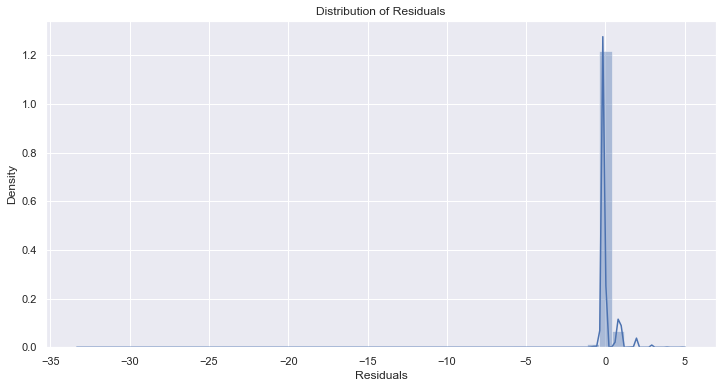

In [36]:
normal_errors_assumption(model_nb,X_train_nb,y_train_nb)

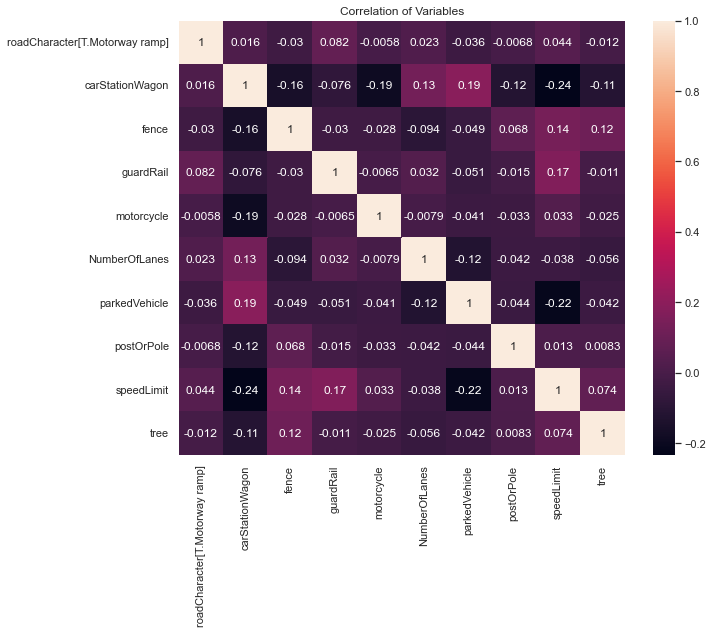

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
roadCharacter[T.Motorway ramp]: 1.0243653677542268
carStationWagon: 3.6938227602705567
fence: 1.1507605259571372
guardRail: 1.070156059874413
motorcycle: 1.0667230412764985
NumberOfLanes: 5.494442814948659
parkedVehicle: 1.1580049927208291
postOrPole: 1.0588432624548496
speedLimit: 5.019661497616941
tree: 1.0659636438608207

0 cases of possible multicollinearity
0 cases of definite multicollinearity

Assumption satisfied


In [37]:
multicollinearity_assumption(model_nb,X_train_nb,y_train_nb,X_train_nb.columns)

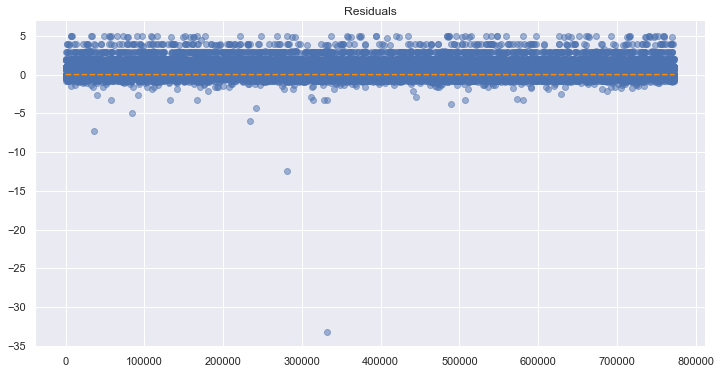

In [38]:
homoscedasticity_assumption(model_nb,X_train_nb,y_train_nb)

predictions made:

In [39]:
ypred_ntrain = model_nb.predict(X_train_nb)
ypred_ntest = model_nb.predict(X_test_nb)

scores:

In [40]:
from sklearn.metrics import mean_squared_log_error
mean_squared_log_error(y_test_nb,ypred_ntest)

0.035019753676175464

In [41]:
RMSE_ntrain = np.sqrt(mean_squared_error(y_train_nb,ypred_ntrain))
print("RMSE Of Negative Binomial for train:",RMSE_ntrain)
MAE_ntrain = mean_absolute_error(y_train_nb,ypred_ntrain)
print("MAE Of Negative Binomial for train:",MAE_ntrain)

RMSE Of Negative Binomial for train: 0.301318862711137
MAE Of Negative Binomial for train: 0.1312075745916933


In [42]:
RMSE_ntest = np.sqrt(mean_squared_error(y_test_nb,ypred_ntest))
print("RMSE Of Negative Binomial for test:",RMSE_ntest)
MAE_ntest = mean_absolute_error(y_test_nb,ypred_ntest)
print("MAE Of Negative Binomial for test:",MAE_ntest)

RMSE Of Negative Binomial for test: 0.30274932010265126
MAE Of Negative Binomial for test: 0.13195964003357133


In [43]:
df_nb_Results = calculate_residuals(model_nb,X_test_nb,y_test_nb)

In [44]:
df_nb_Results['Actual'].value_counts()

0.0    145218
1.0      8072
2.0       891
3.0       168
4.0        54
5.0        36
Name: Actual, dtype: int64

In [45]:
df_nb_Results['PredictedT'].value_counts()

0.0    153922
1.0       487
2.0        24
3.0         3
4.0         1
5.0         1
6.0         1
Name: PredictedT, dtype: int64

### Trying a zero inflated variation of Negative binomial Regression Model

In [ ]:
print("Model: Zero Inflated Neg. Binomial")

zinb_mod = sm.ZeroInflatedNegativeBinomialP(y_train_nb, X_train_nb).fit(method="newton", maxiter=100)

zinb_pred = zinb_mod.predict(X_test_nb, exog_infl=np.ones((len(X_test_nb), 1)))
zinb_rmse = np.sqrt(mean_squared_error(y_test_nb, zinb_pred))

print("RMSE ZINB: ", zinb_rmse)

### Linear regression

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2)

In [ ]:
from sklearn.linear_model import LinearRegression

Lr= LinearRegression()
Lr.fit(X_train,y_train)
pred=Lr.predict(X_test)

print(mean_absolute_error(y_test,pred))
print(r2_score(y_test,pred))

### Gradient Boosting Regressor


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gb= GradientBoostingRegressor()
gb.fit(X_train,y_train)
pred=gb.predict(X_test)

print(mean_absolute_error(y_test,pred))
print(r2_score(y_test,pred))

till now the problem statement is addressed as a regresion problem what if it is seen as a **classification problem**.

### Logistic Regression

In [ ]:
from sklearn.metrics  import f1_score
from sklearn.metrics  import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2)

In [ ]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()
LR.fit(X_train,y_train)

pred = LR.predict(X_test)
print(accuracy_score(y_test,pred))
print(f1_score(y_test,pred,average='micro'))

### Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

DT= DecisionTreeClassifier()
DT.fit(X_train,y_train)

pred=DT.predict(X_test)

print(accuracy_score(y_test,pred))        
print(f1_score(y_test,pred,average='micro'))

### Gradient Boosting Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier


gbc= GradientBoostingClassifier()
gbc.fit(X_train,y_train)

pred=gbc.predict(X_test)

print(accuracy_score(y_test,pred))        
print(f1_score(y_test,pred,average='micro'))